## 预处理数据

In [1]:
import  torch
from src.utils.visualize import plot_visium_overlay

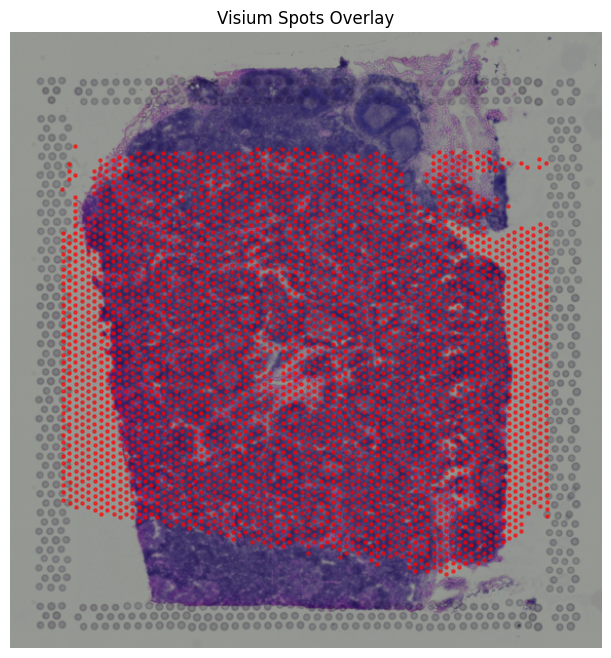

In [2]:

data = torch.load("../data/E1_slide1.pt", weights_only=False)

plot_visium_overlay(
    data,
    img_path="../data/Visium_Human_Lymph_Node/spatial/tissue_lowres_image.png",
    scalefactors_path="../data/Visium_Human_Lymph_Node/spatial/scalefactors_json.json",
    use_hires=False
)

In [3]:
import pandas as pd
features = pd.read_csv("../data/Visium_Human_Lymph_Node/filtered_feature_bc_matrix/features.tsv.gz",
                       sep="\t", header=None)
print(features.head(20))
print(features[1].unique()[:20])  # 打印前20个 gene symbol

                  0            1                2
0   ENSG00000243485  MIR1302-2HG  Gene Expression
1   ENSG00000237613      FAM138A  Gene Expression
2   ENSG00000186092        OR4F5  Gene Expression
3   ENSG00000238009   AL627309.1  Gene Expression
4   ENSG00000239945   AL627309.3  Gene Expression
5   ENSG00000239906   AL627309.2  Gene Expression
6   ENSG00000241860   AL627309.5  Gene Expression
7   ENSG00000241599   AL627309.4  Gene Expression
8   ENSG00000286448   AP006222.2  Gene Expression
9   ENSG00000236601   AL732372.1  Gene Expression
10  ENSG00000284733       OR4F29  Gene Expression
11  ENSG00000235146   AC114498.1  Gene Expression
12  ENSG00000284662       OR4F16  Gene Expression
13  ENSG00000229905   AL669831.2  Gene Expression
14  ENSG00000237491    LINC01409  Gene Expression
15  ENSG00000177757       FAM87B  Gene Expression
16  ENSG00000228794    LINC01128  Gene Expression
17  ENSG00000225880    LINC00115  Gene Expression
18  ENSG00000230368       FAM41C  Gene Expression


## 初始静态L-R通信强度

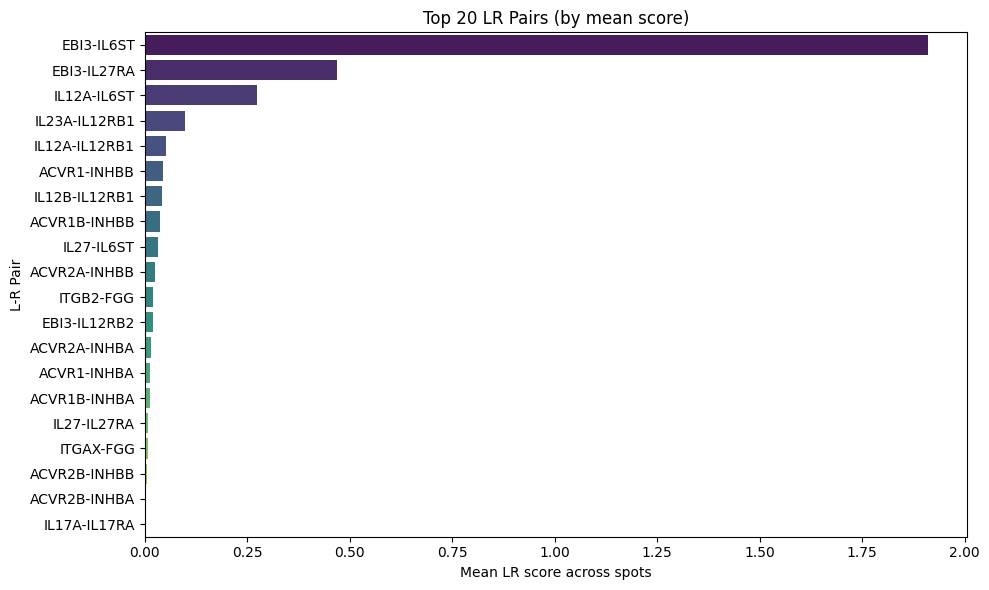

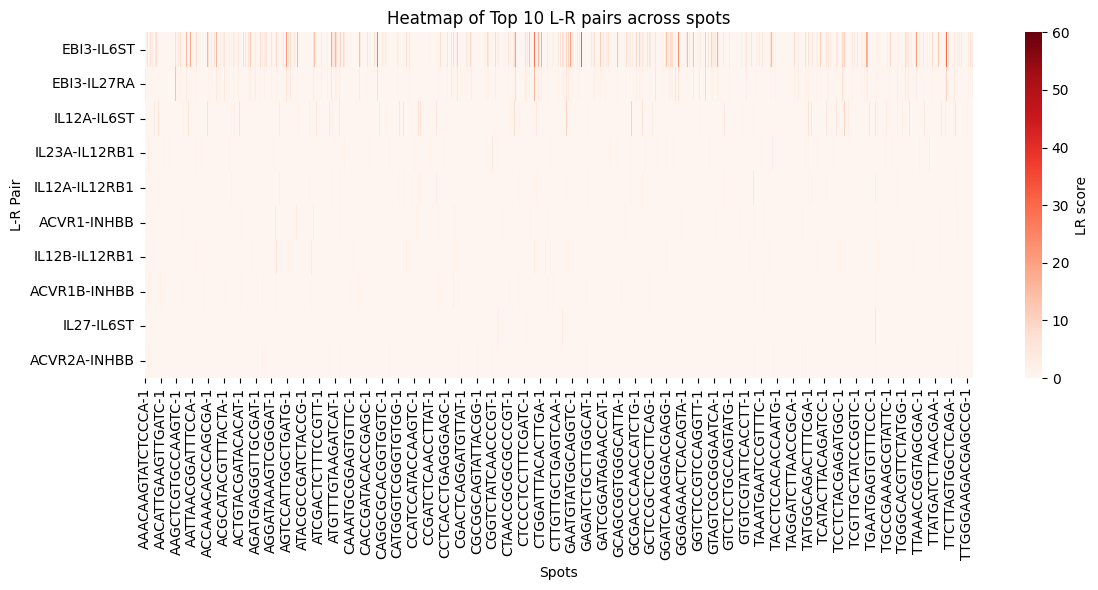

In [4]:
from src.utils.analysis import plot_lr_activity

adata_path = "../data/Visium_Human_Lymph_Node/filtered_feature_bc_matrix"
lr_pairs_path = "../data/lr_pairs.csv"

df_scores = plot_lr_activity(adata_path, lr_pairs_path, top_n=20, heatmap=True)


## 生成图的数据格式

In [5]:
import torch

pt_path = "../data/E1_slide1.pt"

# 1. 读文件
data = torch.load(pt_path, weights_only=False)

# 2. 打印整体 Data 对象
print(data)

# 3. 分别打印字段信息
print("x shape:", data.x.shape)                 # PCA 特征
print("edge_index shape:", data.edge_index.shape) # 图边
print("pos shape:", data.pos.shape)             # 空间坐标
print("raw_expr shape:", data.raw_expr.shape)   # 基因表达矩阵
print("gene_names length:", len(data.gene_names))

# 4. 看一小部分数据
print("前5个基因名:", data.gene_names[:5])
print("前5条边:", data.edge_index[:, :5])
print("第一个spot的PCA特征:", data.x[0, :10])   # 只打印前10维
print("第一个spot的基因表达:", data.raw_expr[0, :10])  # 只打印前10个基因
print("第一个spot坐标:", data.pos[0])


Data(x=[4035, 256], edge_index=[2, 24210], pos=[4035, 2], raw_expr=[4035, 36601], gene_names=[36601])
x shape: torch.Size([4035, 256])
edge_index shape: torch.Size([2, 24210])
pos shape: torch.Size([4035, 2])
raw_expr shape: torch.Size([4035, 36601])
gene_names length: 36601
前5个基因名: ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']
前5条边: tensor([[   0,    0,    0,    0,    0],
        [   0,  431, 2320, 1137, 3928]])
第一个spot的PCA特征: tensor([-2.7564, -1.2237,  1.6234,  0.1274, -0.6844,  0.0705,  0.0676,  0.7439,
         0.1568,  0.2980])
第一个spot的基因表达: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
第一个spot坐标: tensor([6982., 8346.])
